# 1. Problem

In [1]:
import tensorflow as tf

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist_data/", one_hot=False)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz


# 2. Convolutional Neural Network
![](images/cnn.png)

# 3. Train

In [47]:
# Training Parameters
learning_rate = 0.001
num_steps = 3000
batch_size = 128

# Network Parameters
num_input = 784         # MNIST data input (img shape: 28*28)
num_classes = 10        # MNIST total classes (0-9 digits)
dropout = 0.25          # Dropout, probability to drop a unit

In [48]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        return out

In [49]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes,
      loss=loss_op, train_op=train_op, eval_metric_ops={'accuracy': acc_op})

In [50]:
model = tf.estimator.Estimator(model_fn)
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/6p/yqt9w6sx0330_s_nfp4gzzm40000gn/T/tmph64kefl2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11af8a9b0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/6p/yqt9w6sx0330_s_nfp4gzzm40000gn/T/tmph64kefl2/model.ckpt.
INFO:tensorflow:loss = 2.30003, step = 1
INFO:tensorflow:global_step/sec: 21.6235
INFO:tensorflow:loss = 0.268374, step = 101 (4.625 sec)
INFO:tensorflow:global_step/sec: 21.7132
INFO:tensorflow:loss = 0.0686683, step

# 4. Evaluate

In [51]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-07-07-03:48:53
INFO:tensorflow:Restoring parameters from /var/folders/6p/yqt9w6sx0330_s_nfp4gzzm40000gn/T/tmph64kefl2/model.ckpt-3000
INFO:tensorflow:Finished evaluation at 2018-07-07-03:48:54
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.9922, global_step = 3000, loss = 0.0316926


{'accuracy': 0.99220002, 'global_step': 3000, 'loss': 0.03169262}

INFO:tensorflow:Restoring parameters from /var/folders/6p/yqt9w6sx0330_s_nfp4gzzm40000gn/T/tmph64kefl2/model.ckpt-3000


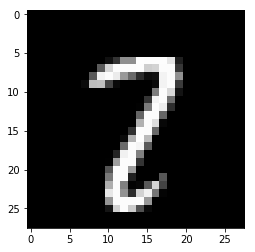

Label:  2      Model prediction: 7


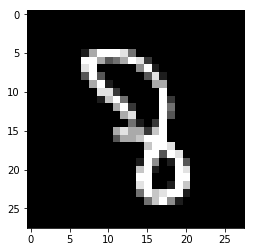

Label:  8      Model prediction: 2


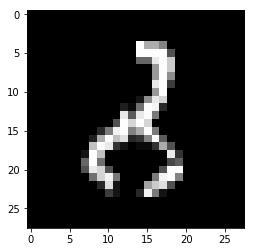

Label:  8      Model prediction: 2


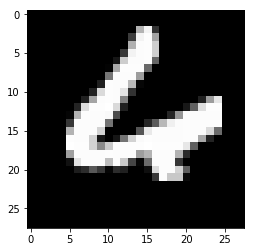

Label:  6      Model prediction: 4


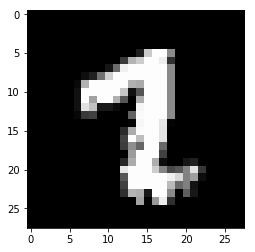

Label:  2      Model prediction: 1


In [52]:
import matplotlib.pyplot as plt
import numpy as np

input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': mnist.test.images}, shuffle=False)
preds = np.asarray(list(model.predict(input_fn)))
error_pred = np.not_equal(preds, mnist.test.labels)
error_images = mnist.test.images[error_pred]
error_labels = mnist.test.labels[error_pred]
error_p = preds[error_pred]

for i in range(5):
    plt.imshow(np.reshape(error_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Label: ", error_labels[i], "     Model prediction:", error_p[i])